In [ ]:
!aws s3 cp s3://lowresolutionhighresolution/dataset/ . --recursive

In [ ]:
!pip install -U opencv-python
!yum upgrade
!yum update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)
!pip install --upgrade tensorflow
!pip install numpy --upgrade

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
print (tf.__version__)

In [ ]:
bucket = 'arn:aws:s3:::lowresolutionhighresolution'

import boto3
conn = boto3.client('s3')
response = conn.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(bucket["Name"])
# contents = conn.list_objects(Bucket=bucket)['Contents']
# conn.list_objects(Bucket='lowresolutionhighresolution')

In [ ]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            #img = process_image(img)
            high_res_images.append(img)
        
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
            if filename in filenames: # check for non-present images
                img = cv2.imread(os.path.join(dirname, filename))
                #img = process_image(img)
                low_res_images.append(img)
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    return mean_centered_low_res, mean_centered_high_res

In [ ]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')
#train_x = train_x[:-1]

In [ ]:
train_small = False
if train_small:
    mask = range(0, 1)
    train_x = train_x[mask]
    train_y = train_y[mask]
print (train_x.shape, train_y.shape)

In [ ]:
train_x.shape
assert (train_x.shape[0] == train_y.shape[0]), (f"{train_x.shape[0]} {train_y.shape[0]}")

In [ ]:
val_x.shape
assert (val_x.shape[0] == val_y.shape[0]), (f"{val_x.shape[0]} {val_y.shape[0]}")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[1])
ax2.title.set_text("high-res image ")

In [ ]:
## Generating a NEW architecture with BN and 

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print (tf.__version__)

In [ ]:
def build_model1():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l6)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:

# https://keras.io/api/layers/initializers/
# The Glorot normal initializer, also called Xavier normal initializer.
"""
def build_model2():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l6)
    
    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l9)

    #l11 = add([l5, l10])
    l12 = UpSampling2D()(l10)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l11)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l13)

    #l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotUniform(seed=None,dtype=tf.dtypes.float32))(l14)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model
"""

In [ ]:
model_type = 1
model = None
with tf.device('/device:GPU:0'):
    if model_type == 1:
        model = build_model1()
    elif model_type == 2:
        model = build_model2()
    else:
        assert False
    train_x , train_y = train_x , train_y
    val_x , val_y = val_x, val_y

In [ ]:
model.summary()

In [ ]:
def train(model, train_x, train_y, epochs = 1, batch_size = 32, shuffle = False):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)

In [ ]:
train(model, train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)

In [ ]:
tf.saved_model.save(model, base_dir + "saved_model_" + str(model_type))

In [ ]:
if train_small:
    predict_y = model.predict(train_x)
    #plt.subplots(2,2,figsize=(15,15))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
    plt.figure(figsize=(40,40))
    ax1.imshow(train_x[0])
    ax1.title.set_text("low-res image ")
    ax2.imshow(train_y[0])
    ax2.title.set_text("high-res image ")
    ax3.imshow(predict_y[0])
    ax3.title.set_text("model's output")

In [ ]:
predict_y = model.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[20])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[20])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[20])
ax3.title.set_text("model's output")

In [ ]:
tee = np.expand_dims(val_x[0],axis=0)
tee.shape

In [ ]:
import time
num=0

def run_and_return_image(num):
    
    tee = np.expand_dims(val_x[num],axis=0)

    start = time.time()
    pred_next = model.predict(tee)
    end_time = time.time()-start
    print('It took this long to run inference {}'.format(end_time))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
    plt.figure(figsize=(40,40))
    ax1.imshow(val_x[num])
    ax1.title.set_text("low-res image ")
    ax2.imshow(val_y[num])
    ax2.title.set_text("high-res image ")
    ax3.imshow(pred_next[0])
    ax3.title.set_text("model's output")
    return None


In [ ]:
def run_image_localizer(numpy_image):
    
    image = np.expand_dims(numpy_image,axis=0)
    pred_next = model.predict(image)
    return  pred_next[0]

In [ ]:
def run_multiple_times(num,numpy_image):
    
    for run in range(0,num+1):
        image = run_image_localizer(numpy_image)
        numpy_image = image
    return numpy_image

In [ ]:
Zee= run_multiple_times(2,val_x[50])

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[50])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[50])
ax2.title.set_text("high-res image ")
ax3.imshow(Zee)
ax3.title.set_text("model's output")

In [ ]:
run_and_return_image(25)










ANALYSIS OF ERROR TO UNDERSTAND WHICH PARTS OFTHE IMAGES ARE NOT GETTING ENHANCED AS WELL AS THEY SHOULD 











In [361]:
val_pred = model.predict(val_x)

In [362]:
pred_mse = (np.square(val_pred - val_y))
pred_mse = np.mean(pred_mse, axis=(1, 2, 3), keepdims=True)
#pred_mse[0:10]

In [365]:
pred_mse = pred_mse.squeeze()
pred_arg_sort = pred_mse.argsort()
#pred_arg_sort[0:10]
#pred_mse[pred_arg_sort[0:10]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

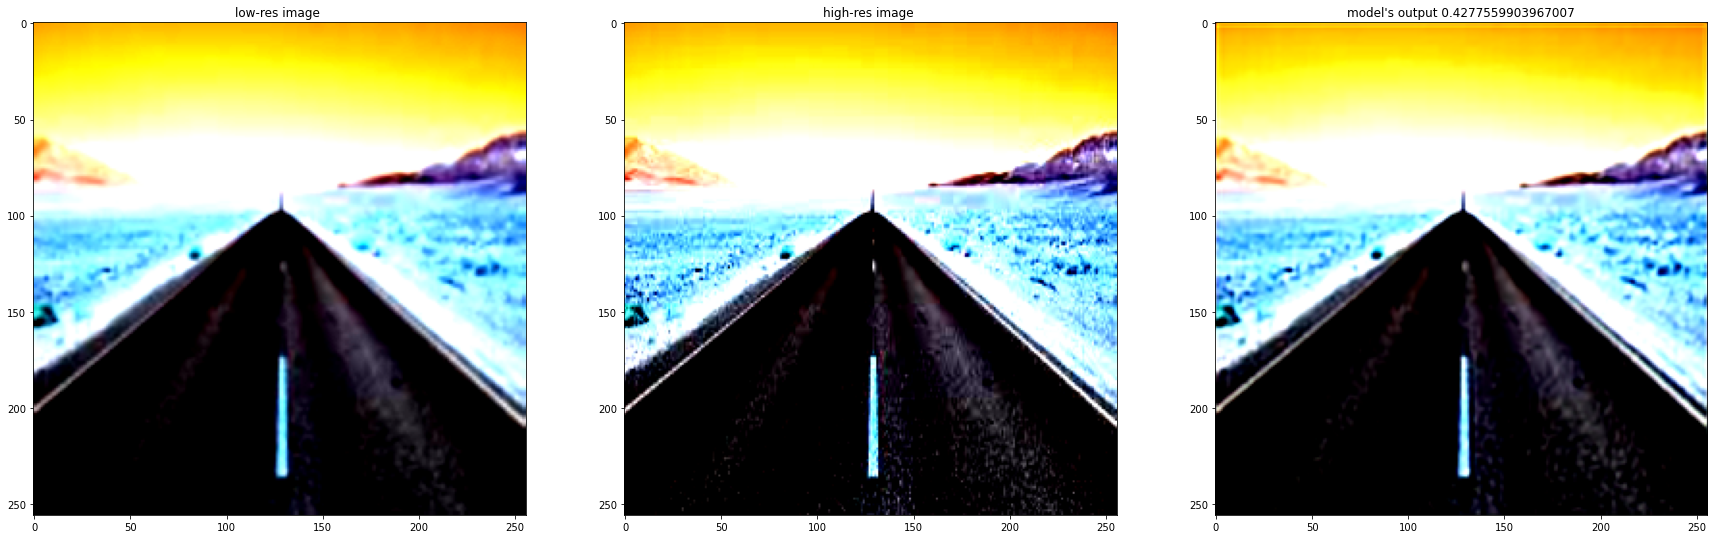

<Figure size 2160x2160 with 0 Axes>

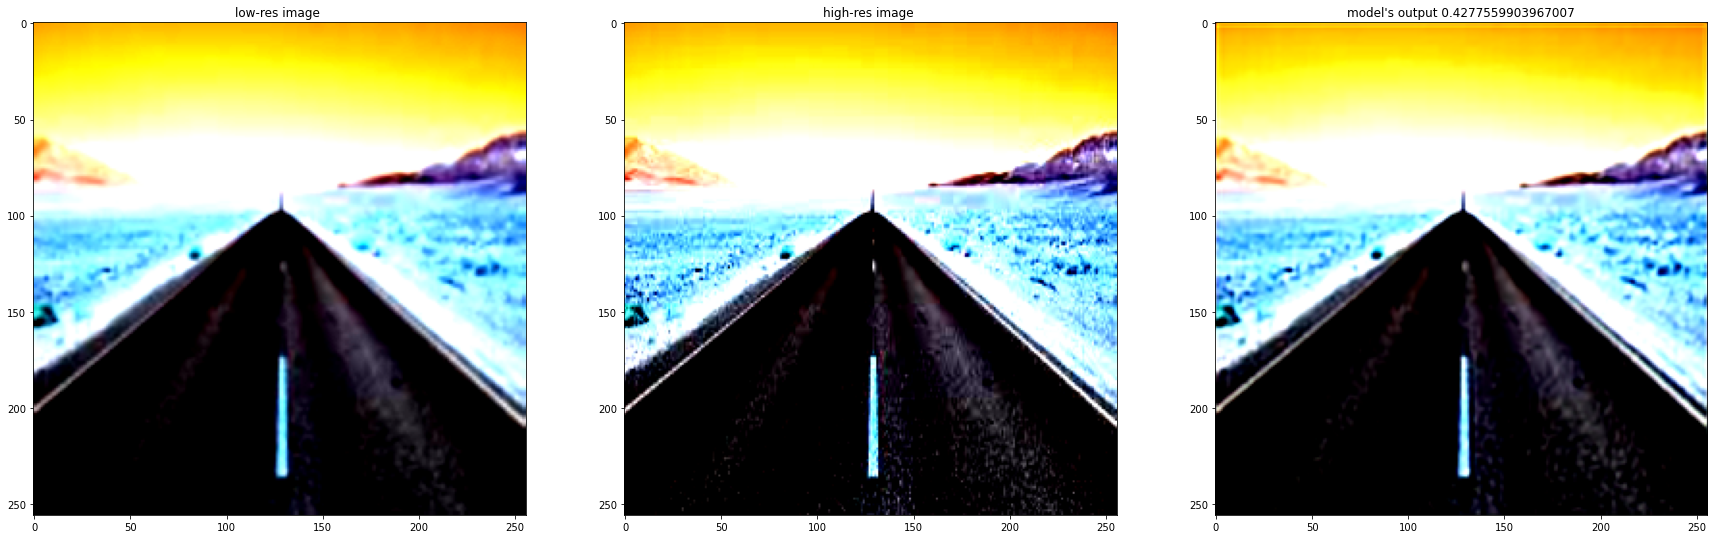

<Figure size 2160x2160 with 0 Axes>

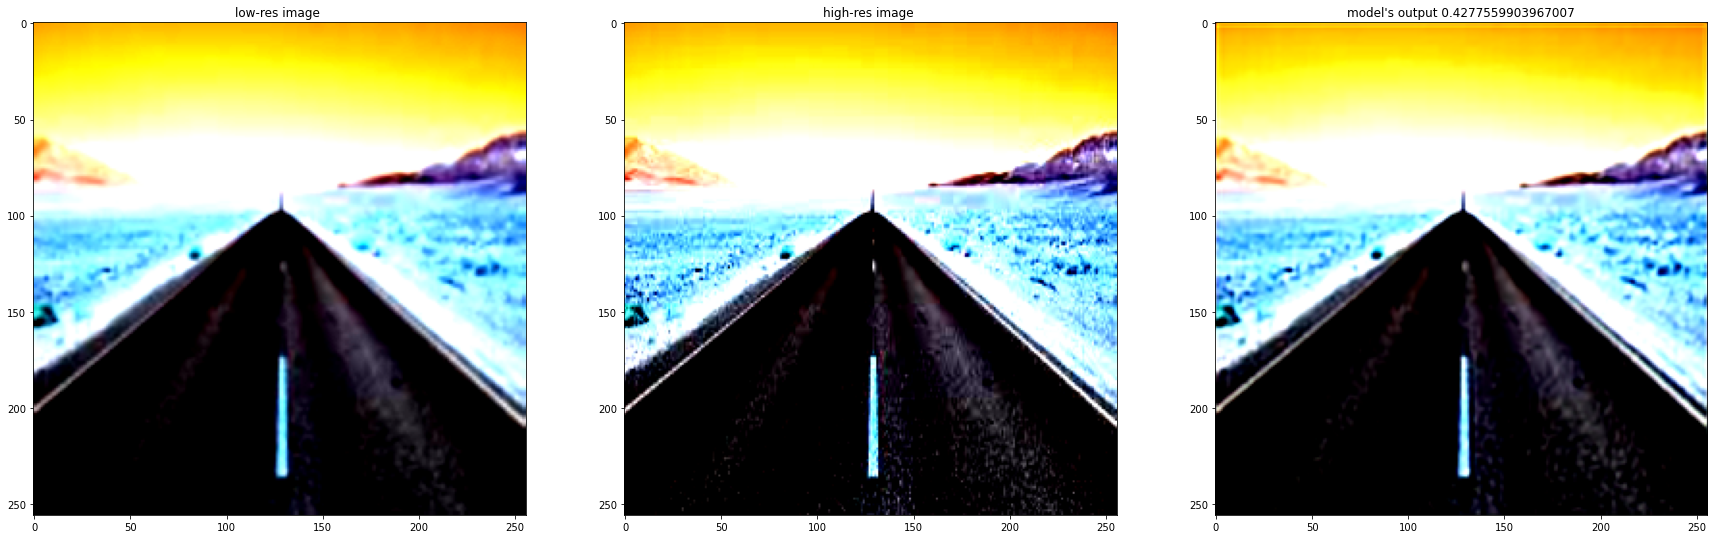

<Figure size 2160x2160 with 0 Axes>

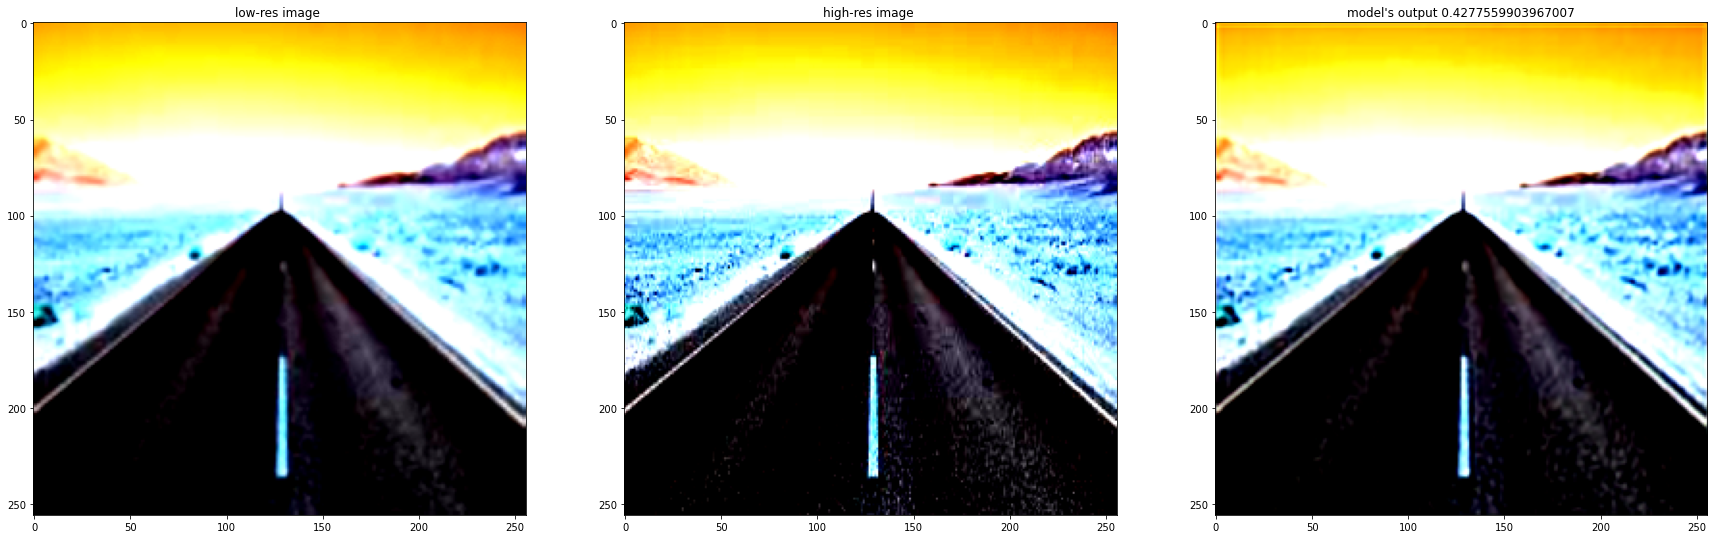

<Figure size 2160x2160 with 0 Axes>

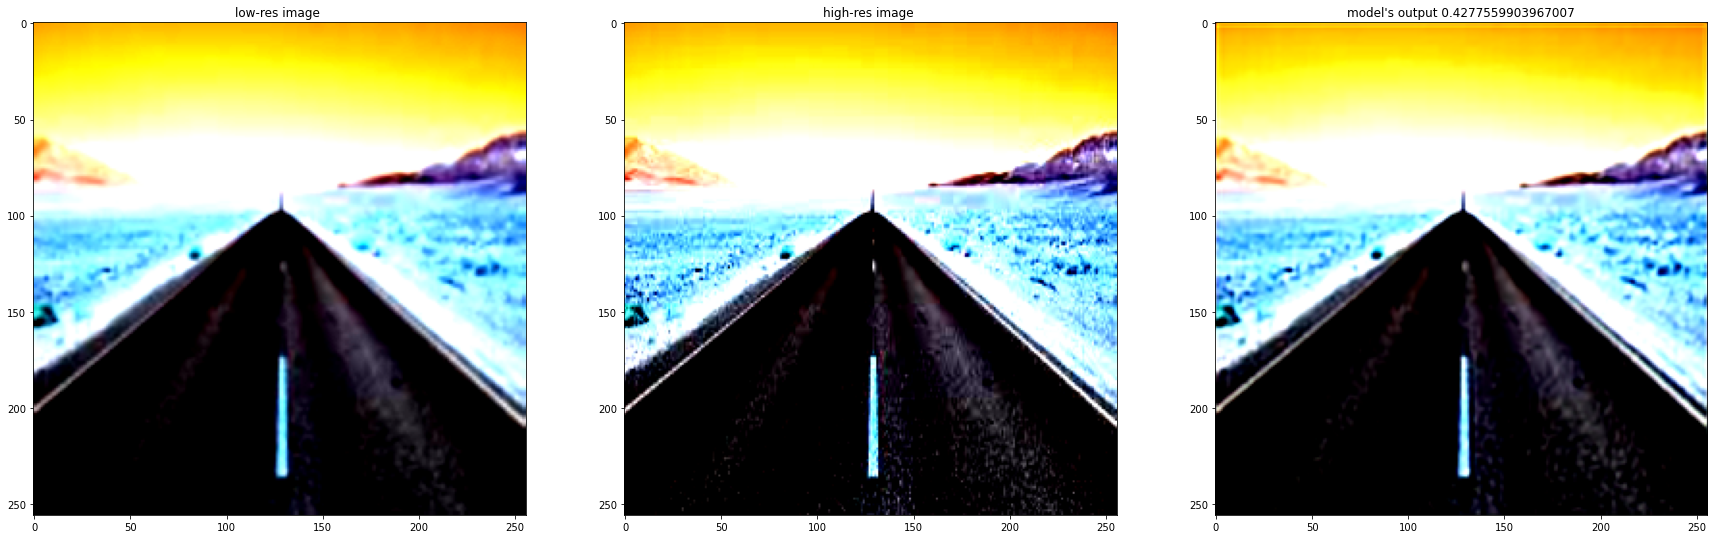

<Figure size 2160x2160 with 0 Axes>

In [392]:
%matplotlib inline
def plot_image(mse, arg_sort, span, best=True):
    def plot_helper(mse, arg_sort, index):
        val_index = arg_sort[index]
        mse_value = mse[index]
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
        plt.figure(figsize=(30,30))
        ax1.imshow(val_x[val_index])
        ax1.title.set_text("low-res image ")
        ax2.imshow(val_y[val_index])
        ax2.title.set_text("high-res image ")
        ax3.imshow(val_pred[val_index])
        ax3.title.set_text(f"model's output {mse_value}")
    
    if best:
        for index in range(0, span):
            plot_helper(mse, arg_sort, span)
    else: 
        for index in range(-1, -1 -span, -1):
            plot_helper(mse, arg_sort, index)
        
        
plot_image(pred_mse, pred_arg_sort, 5, best=True)
